# Step 5: Fit to full RaCA dataset. No minibatching.

Instead of batches of 100, fit to all 120,000 spectra simultaneously.

In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

In [2]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [3]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [20]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [21]:
dataI = dataI[:100,:]
sample_soc = sample_soc[:100]

In [22]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/100 [00:00<?, ?it/s]

# Fit to 121,376/121,376 data points

In [23]:
KEndmembers = 90
NPoints = dataI.shape[0]
NData = dataI.shape[0]
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [24]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

/tmp/ipykernel_16749/1935071162.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,35])


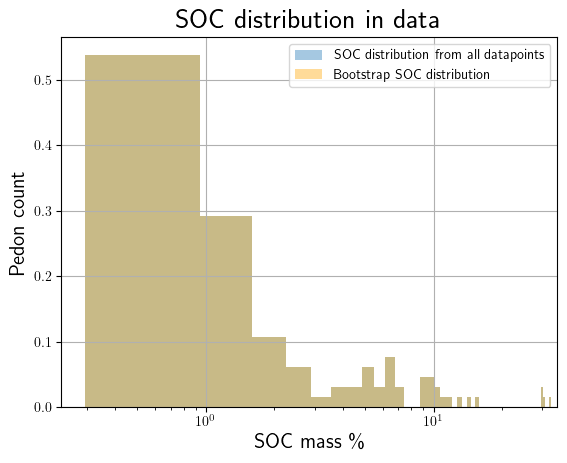

In [25]:
dataIndices = np.random.choice(NData,NPoints,replace=False)
msoc = sample_soc[dataIndices]

plt.hist(sample_soc, bins=50, density=True, alpha=0.4, label='SOC distribution from all datapoints')
plt.hist(msoc, bins=50, density=True, alpha=0.4, color='orange', label='Bootstrap SOC distribution')
plt.xlabel("SOC mass \%",fontsize=15)
plt.ylabel("Pedon count",fontsize=15)
plt.title("SOC distribution in data",fontsize=20)
plt.xscale('log')
plt.xlim([0,35])
plt.legend()
plt.grid()

msoc=msoc/100.0

In [26]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [27]:
# generate seed alphas from seed M's, specified below from initial literature
seedMsDict = {}
def genSeedMs() :
    for endMem in endMemList :
        if "Coarse measure of average abundance" in endMemMap[endMem] :
            seedMsDict[endMem] = float(endMemMap[endMem]["Coarse measure of average abundance"])/100.
        else :
            print("\t - Mineral",endMem,"Does not have any abundance set in the JSON file.")

    # collect constant seeds from the definitions above
    seedMs = [seedMsDict[x] if x in seedMsDict else 0.0 for x in endMemList]
    seedMs = seedMs + [0.0]

    # make seedMs an N x K matrix
    seedMs = np.ones([NPoints,KEndmembers]) * seedMs
    seedMs[:,KEndmembers-1] = msoc
    seedMrem = 1.0 - np.sum(seedMs,axis=1)

    # if seedM remainder is < 0, SOC exceeds pre-defined content,
    # so rescale pre-defined values, fix SOC to prior value, and set rest to 0
    seedMNegRem = (seedMs.T * (seedMrem < 0.0).astype('float32') / np.sum(seedMs[:,:-1],axis=1) * (1.0 - msoc)).T
    seedMNegRem[:,-1] = msoc * (seedMrem < 0.0).astype('float32')
    seedMs = (seedMs.T * (seedMrem >= 0.0).astype('float32')).T + seedMNegRem
    
    # get seeds that haven't been filled in yet, excluding SOC
    # if remaining mass fraction is < 0, exclude from further partitioning
    seedMZeros = ((seedMs == 0.0).astype('float32').T * (seedMrem > 0.0).astype('float32')).T
    
    # sample random remaining seeds and renormalize to the appropriate remainder
    seedMZeros = seedMZeros * np.random.random([NPoints,KEndmembers])
    seedMZeros[:,-1] = 0.0
    
    seedMZeros = (seedMZeros.T / (np.sum(seedMZeros,axis=1)+0.00000000001)).T
    seedMrem = 1.0 - np.sum(seedMs,axis=1)
    seedMZeros = (seedMZeros.T * seedMrem).T
    seedMZeros[:,-1] = 0.0

    # add remaining seeds into seedMs
    seedMs = seedMs + seedMZeros 

    del seedMZeros, seedMrem
    
    return seedMs

seedMs = genSeedMs()

### Generate SOC seed F

In [28]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
F = np.array(F + [seedFsoc])

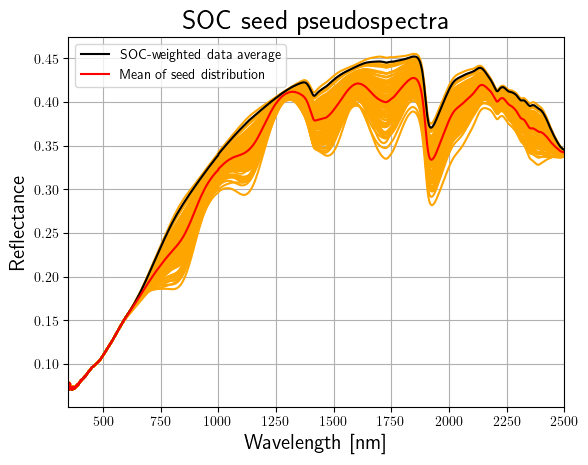

In [29]:
# Generate many seeds for comparison
seedFsocs = np.tile(tFsoc,(100,1))

for i in range(seedFsocs.shape[0]) :
    seedFsocs[i,:] = seedFsocs[i,:] - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)
    
plt.plot(XF,seedFsocs.T, 'orange')
plt.plot(XF,tFsoc.T, 'black',label="SOC-weighted data average")

plt.plot(XF,trueFsoc.T, 'red', label="Mean of seed distribution")

plt.legend()

plt.xlim([350,2500])

plt.xlabel("Wavelength [nm]",fontsize=15)
plt.ylabel("Reflectance",fontsize=15)
plt.title("SOC seed pseudospectra",fontsize=20)
plt.grid()

#plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [30]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA,axis=1)).t()

rhorads = np.array(rhos)*np.array(rads)
trueSOCrr = np.mean(rhorads)
seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
seedAs = A(seedMs,np.append(rhorads,seedSOCrr))

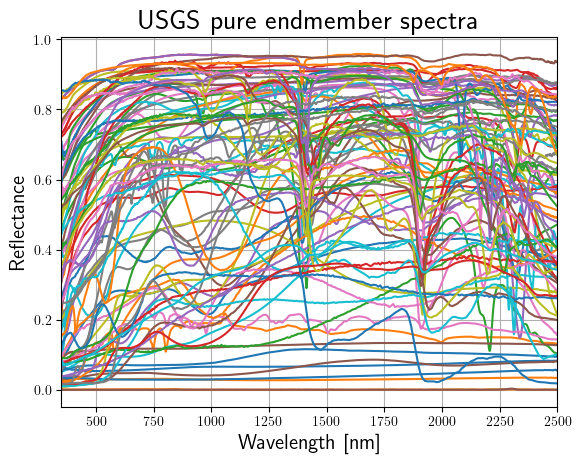

In [31]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

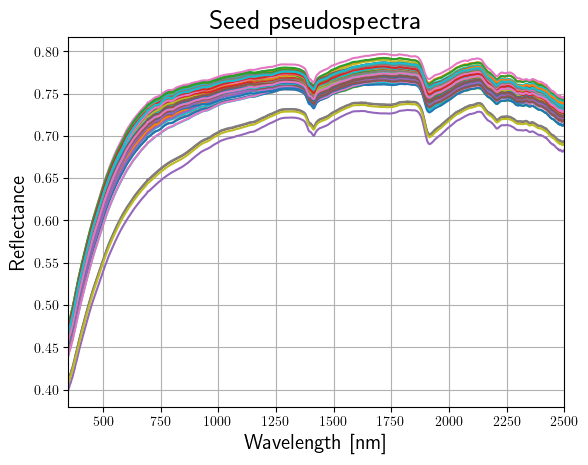

In [32]:
plt.plot(XF,np.dot(seedAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

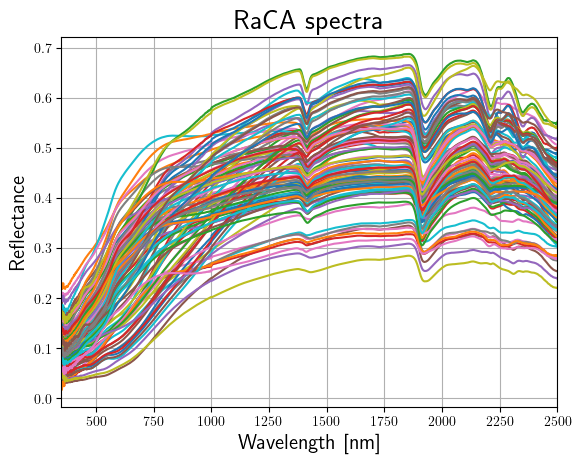

In [34]:
plt.plot(XF,dataI[dataIndices].T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'RaCA spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

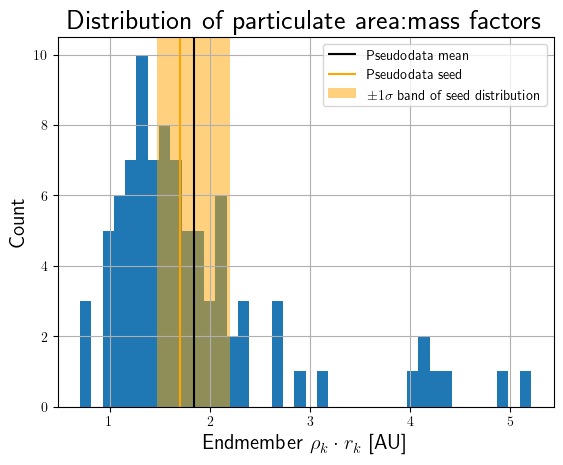

In [35]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)
plt.grid()

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Pseudodata mean');
plt.vlines(seedSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Pseudodata seed');
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

### Run fit

In [36]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF) # + 10000.0*omrs
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.bdsFLoss[self.epoch] = oobsF.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

In [37]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F[:-1,:].tolist())
tFsoc    = torch.tensor(seedFsoc.tolist())
tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
tmsoc    = torch.tensor(msoc.tolist())
trhorads = torch.tensor(rhorads.tolist())
trrsoc   = torch.tensor(seedSOCrr)

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))

nepochs = 10000
model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.99,0.999))

In [38]:
for epoch in tqdm(range(nepochs)) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.01 ** 2) / (NPoints*MSpectra))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch  9999 :  438.61700439453125 384.4186706542969 17.87162578588084


1.6070325959124168 1.697060083810912 1.8363792196655018


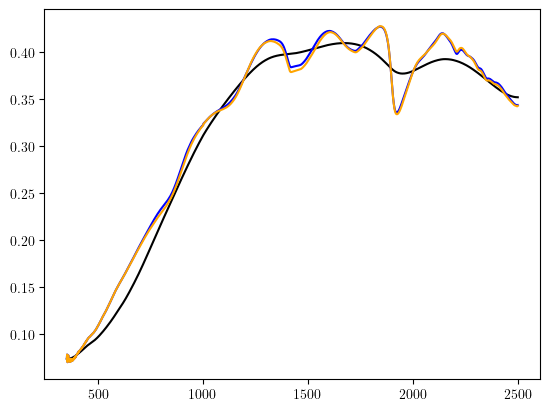

In [39]:
plt.plot(XF,model.fsoc.detach().numpy(),'black')
plt.plot(XF,seedFsoc,'blue')
plt.plot(XF,trueFsoc,'orange')
print(model.rrsoc.detach().item(),seedSOCrr[0],trueSOCrr)

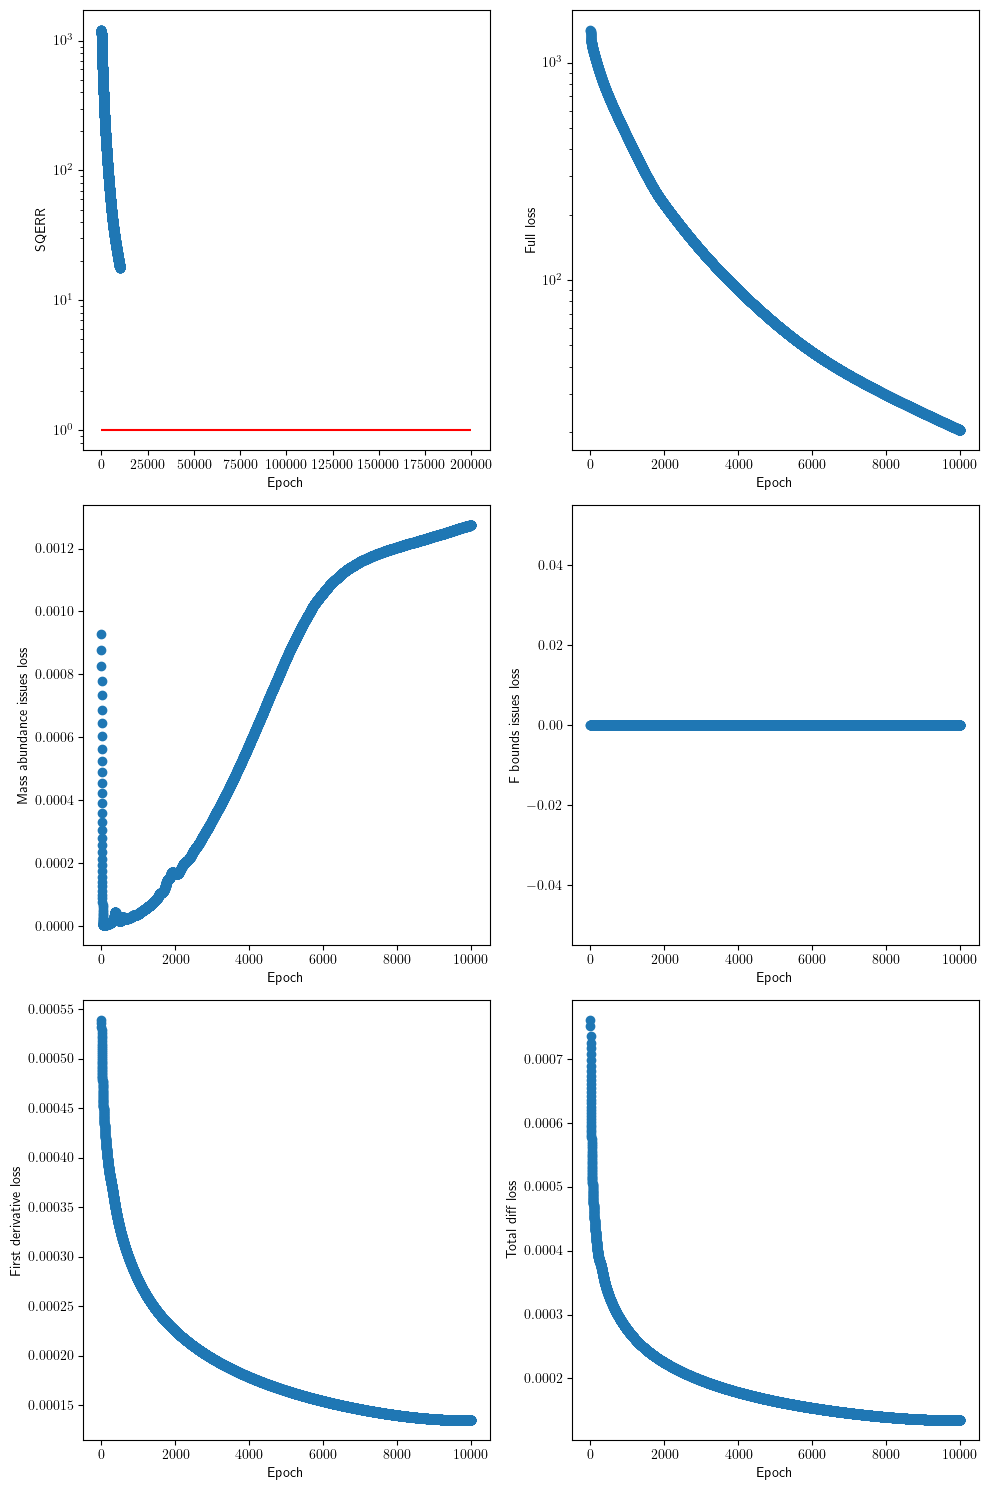

In [40]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq / (0.01 ** 2) / (NPoints*MSpectra))
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")
axarr[0,0].hlines(1,xmin=0,xmax=200000,color='r')
axarr[0,0].set_yscale("log")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss / (0.01 ** 2) / (NPoints*MSpectra))
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")
axarr[0,1].set_yscale("log")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.bdsFLoss))],model.bdsFLoss)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("F bounds issues loss")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()

  0%|          | 0/89 [00:00<?, ?it/s]

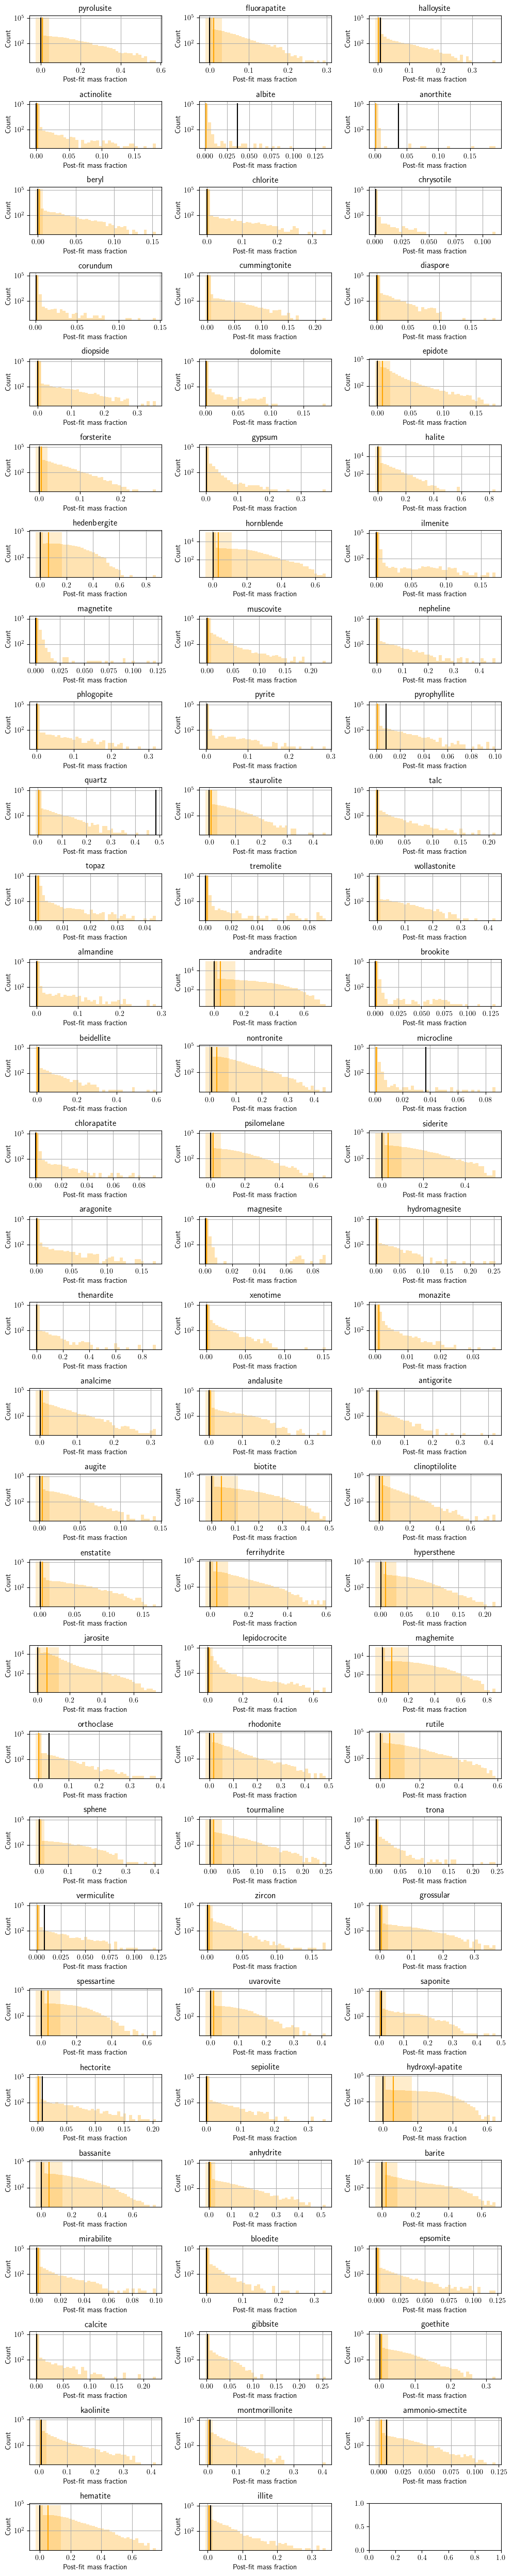

In [ ]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(model.ms.detach().numpy().shape[1])):

    col = index % 3
    
    tcorrms = np.array(model.ms.tolist())
    tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
    tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
    
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(tcorrms[:,iEndmember],bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(tcorrms[:,iEndmember])
    sd = np.sqrt(np.var(tcorrms[:,iEndmember]))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()

In [41]:
import pickle

with open('step5_first100_E10k_lr0p00002_b1_0p99_b2_0p999.pkl', 'wb') as file:
        pickle.dump((model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)

In [3]:
import pickle

with open('step5_fullFit_E200k_lr0p00002_b1_0p99_b2_0p999.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

Significant differences for quartz, microcline, vermiculite?, orthoclase, pyrophyllite, albite, anorthite, 